## Decode white matter tracts

This file was written by Julio Peraza and modified by Sohmee Kim.
The gradec package must be installed from github to decode white matter tracts.

This code is split into two major sections:
(1) Decoding
(2) Figure combination.

1. Decoding
    - Train LDA-based decoder using NeuroQuery base
    - Users can choose to run the decoder on each region separately (LPI, RAS) or combined (LPI+RAS)
    - During this step, three figures are generated: (1) surface plot, (2) word cloud, (3) radar plot
2. Figure combination
    - Given that there are many figures generated for each tract, the figures can be combined into single files
    - Each file is currently set to combine figures for 6 tracts. This can be changed by the user

In [ ]:
# If on brainlife, use ! due to version issue on brainlife
!pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
!pip install git+https://github.com/JulioAPeraza/gradec.git

In [1]:
import itertools
import os.path as op
import os
import glob # imported for csv creation. can be removed
import csv # imported for csv creation. can be removed
import pandas as pd

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib
import numpy as np

### Create csv file with all tract names

In [21]:
file_dir = os.getcwd() + "/data/white-matter-atlas_thresholds/cortexmap_binarize_smooth-surf-1_threshold-0.15_dilate-0/cortexmap/func"
file_names = []

# extract all .gii file names
for x in os.listdir(file_dir):
    if x.endswith(".gii"):
        file_names.append(x)

regions_bi = [] # tracts with 2 endpoint ROIs
regions_mono = [] # tracts with 1 endpoint ROIs

# extract tract name from file name
for i in file_names:
    split_region = i.split("_")[0][3:]
    if split_region.find('left') == 0:
        regions_bi.append(split_region[4:])
    elif split_region.find('right') == 0:
        regions_bi.append(split_region[5:])
    else:
        regions_mono.append(split_region)

# save tract names to csv file
#np.array(regions_mono).tofile("regions_mono.csv", sep = ",")
#np.array(regions_bi).tofile("regions_bi.csv", sep = ",")

tract_names = sorted(list(set(regions_bi))) + sorted(list(set(regions_mono)))
tract_names = sorted(list(set(regions_mono)))

### Define space, density and paths to data

In [22]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

data_dir = op.join(".", "data")
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

# List of possible combinations of tracts, regions and smoothing
tracts = tract_names
regions = ["RAS", "LPI"]
smths = ["", ".smooth_1"]
thresholds = ["0", "0.15", "0.25"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(tract_names, tract_names))
REGIONS_DICT = {
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
}

### Train and LDA-based decoder on NeuroQuery detabase

In [23]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Run decoder on each regions separate

In [26]:
sep_figures_dir = op.join(figures_dir, "separated")
os.makedirs(sep_figures_dir, exist_ok=True)

separated_results = {}
for fig_i, (threshold, tract, region, smth) in enumerate(itertools.product(thresholds, tracts, regions, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lh = op.join(regions_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_rh = op.join(regions_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    # map_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    # map_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_{region}_FiberEndpoint{smth}.func.gii")
    map_arr_lh = nib.load(map_lh).agg_data()
    map_arr_rh = nib.load(map_rh).agg_data()

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    filtered_df.columns = ["r"]
    separated_results[f"{tract}_{region}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} {REGIONS_DICT[region]}\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png"),
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png"), # save out to png
        )
        
        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png"), # save out to png
        )

  0%|          | 0/1 [00:00<?, ?it/s]


### Run decoder on combined regions for each tract

In [ ]:
com_figures_dir = op.join(figures_dir, "combined")
os.makedirs(com_figures_dir, exist_ok=True)

combined_results = {}
for fig_i, (threshold, tract, smth) in enumerate(itertools.product(thresholds, tracts, smths)):
    # Path to the maps
    regions_dir = op.join(
        data_dir, 
        "white-matter-atlas_thresholds", 
        f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
        "cortexmap", 
        "func",
    )
    
    # Read maps
    map_lpi_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_lpi_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint{smth}.func.gii")
    map_ras_lh = op.join(regions_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    map_ras_rh = op.join(regions_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint{smth}.func.gii")
    
    map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
    map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
    map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
    map_ras_arr_rh = nib.load(map_ras_rh).agg_data()

    # Combined regions for each tract
    map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
    map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
    
    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Decode map
    corrs_df = decode.transform([map_arr], method="correlation")
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    filtered_df.columns = ["r"]
    combined_results[f"{tract}{smth}_thr-{threshold}"] = filtered_df.sort_values(by="r", ascending=False)

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\n{SMTHS_DICT[smth]}. Threshold: {threshold}",
        data_dir=data_dir,
        out_fig=op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png"), # save out to png
    )

    # Visualize results
    corrs = filtered_df["r"].to_numpy()
    if not np.any(np.isnan(corrs)) and corrs.size > 0: # Skip one of the regions of CST
        # Radar plot
        plot_radar(
            corrs, 
            filtered_features, 
            MODEL,
            out_fig=op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png"), # save out to png
        )

        # Word cloud plot
        plot_cloud(
            corrs, 
            filtered_features,
            MODEL,
            frequencies=filtered_frequencies,
            out_fig=op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png"), # save out to png
        )

  0%|          | 0/1 [00:00<?, ?it/s]
/home/sohmee/.local/share/virtualenvs/test-uar988OR/lib/python3.10/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encountered in true_divide
  rs = temp / (datass[1:] * datass[0])
  0%|          | 0/1 [00:00<?, ?it/s]


### Make figures

In [27]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

### Make figures for separated regions dataset

saved to file: ./data/figures/results-separated_1.png
saved to file: ./data/figures/results-separated_2.png
saved to file: ./data/figures/results-separated_3.png
saved to file: ./data/figures/results-separated_4.png
saved to file: ./data/figures/results-separated_5.png
saved to file: ./data/figures/results-separated_6.png
saved to file: ./data/figures/results-separated_7.png
saved to file: ./data/figures/results-separated_8.png
saved to file: ./data/figures/results-separated_9.png
saved to file: ./data/figures/results-separated_10.png


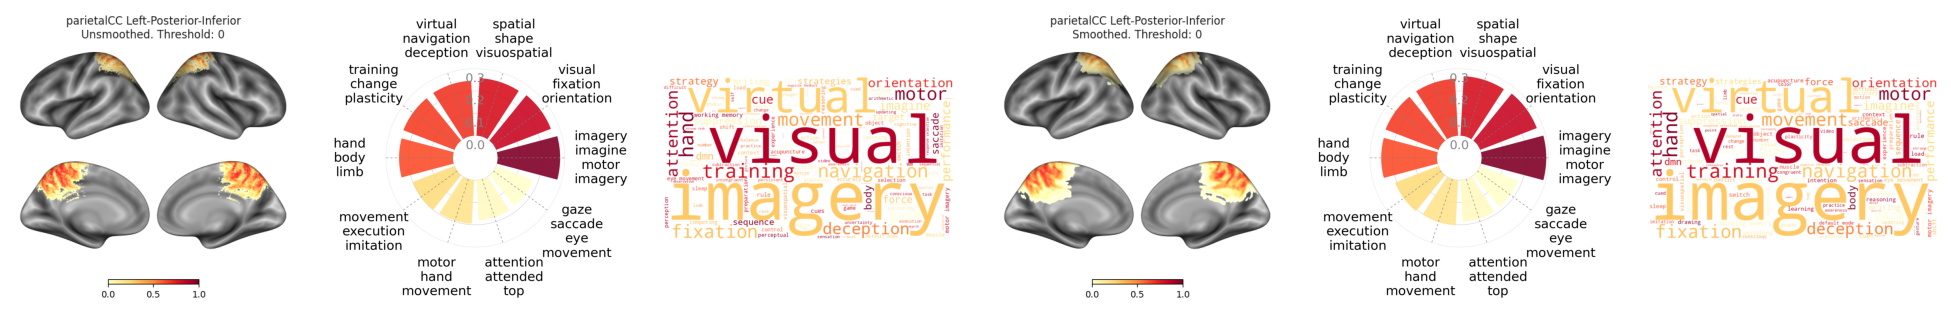

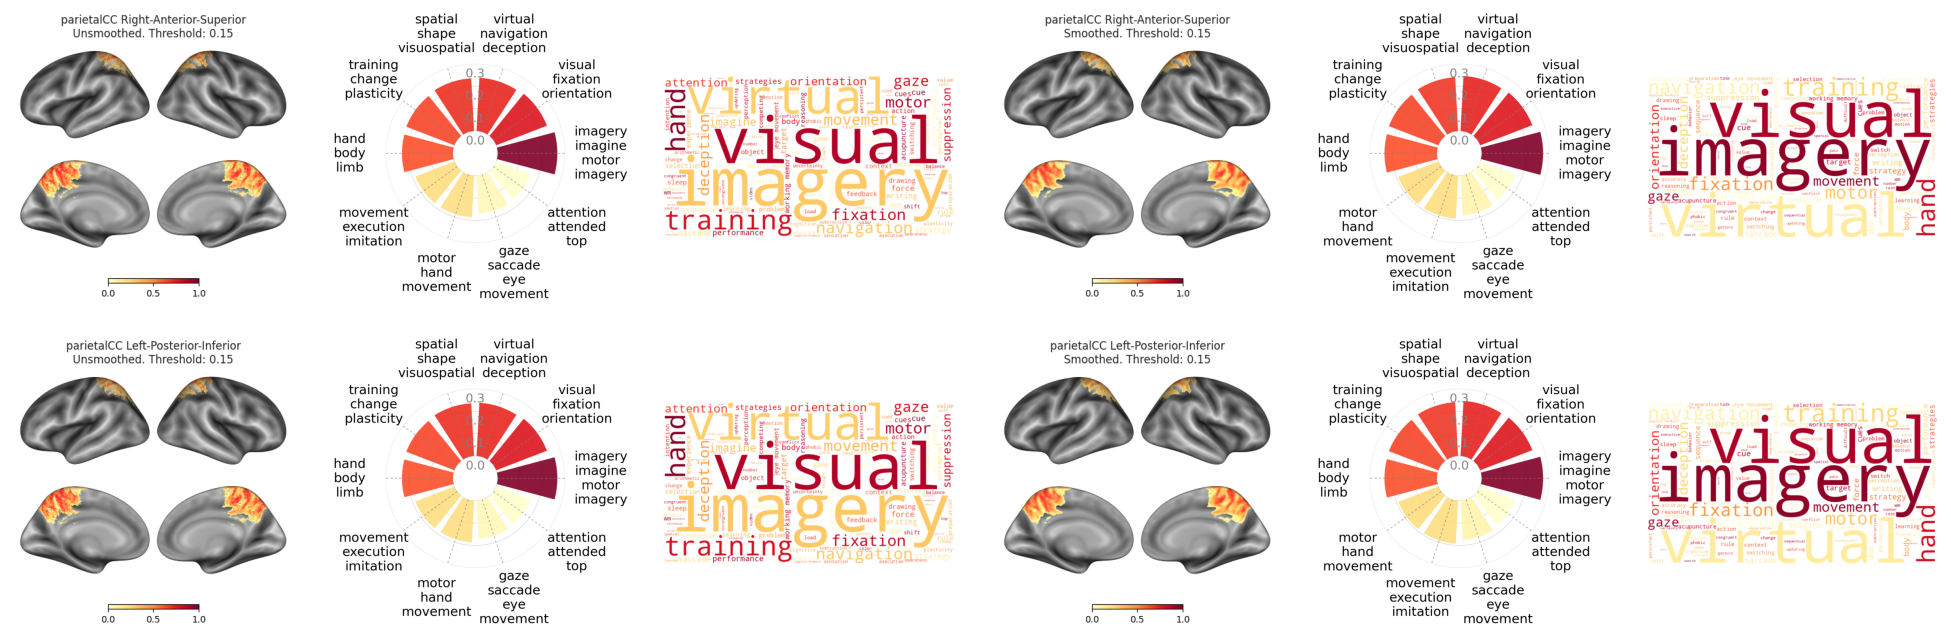

<Figure size 2500x2500 with 0 Axes>

In [28]:
sep_width, sep_hight = 25, 25
n_sep_rows, n_sep_cols = 6, 6

fig_i = 0 # figure num
file_i = 0 # num of output file
plt_types_num = 3 # surface, radar, and wordcloud
total_fig_num = len(thresholds) * len(tracts) * len(smths) * len(regions)
regions_num = len(regions)

# figures directory
data_dir = op.join(".", "data")
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")
sep_figures_dir = op.join(figures_dir, "separated")

for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(sep_width, sep_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_sep_rows, ncols=n_sep_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for reg_i, region in enumerate(regions):
            for smth_i, smth in enumerate(smths):
                surf_plt = op.join(sep_figures_dir, f"{fig_i}-01_{tract}_{region}{smth}_thr-{threshold}_surf.png")
                radar_plt = op.join(sep_figures_dir, f"{fig_i}-02_{tract}_{region}{smth}_thr-{threshold}_radar.png")
                wordcloud_plt = op.join(sep_figures_dir, f"{fig_i}-03_{tract}_{region}{smth}_thr-{threshold}_wordcloud.png")

                for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                    ax_trc = trc_i % plt_types_num
                    if ax_trc < 0:
                        ax_trc = trc_i                        
                    ax = fig.add_subplot(gs[ax_trc*regions_num + reg_i, smth_i*plt_types_num + img_i], aspect="equal")
                    if op.exists(img_file):
                        img = mpimg.imread(img_file)    
                        ax.imshow(img)
                    ax.set_axis_off()

                fig_i += 1
                # output file with multiple plots
                if (fig_i % n_sep_rows == 0 or (fig_i == total_fig_num)):
                    file_i += 1
                    out_file = op.join(figures_dir, "results-separated_" + str(file_i) +".png")
                    fig.savefig(out_file, bbox_inches="tight", dpi=300)
                    print("saved to file: " + out_file)
                    plt.clf()

### Make figures for combined regions dataset

In [ ]:
comb_width, comb_hight = 25, 13
n_comb_rows, n_comb_cols = 4, 6

fig_i = 0 # figure num
file_i = 0 # num of output file
plt_types_num = 3 # surface, radar, and wordcloud
total_fig_num = len(thresholds) * len(tracts) * len(smths)

# figures directory
data_dir = op.join(".", "data")
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")
com_figures_dir = op.join(figures_dir, "combined")

# iterate through all combination of thresholds, tracts, and smoothings to create combined fig
for thr_i, threshold in enumerate(thresholds):
    fig = plt.figure(figsize=(comb_width, comb_hight))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    gs = GridSpec(nrows=n_comb_rows, ncols=n_comb_cols, figure=fig)

    for trc_i, tract in enumerate(tracts):
        for smth_i, smth in enumerate(smths):
            surf_plt = op.join(com_figures_dir, f"{fig_i}-01_{tract}_LPI+RAS{smth}_thr-{threshold}_surf.png")
            radar_plt = op.join(com_figures_dir, f"{fig_i}-02_{tract}_LPI+RAS{smth}_thr-{threshold}_radar.png")
            wordcloud_plt = op.join(com_figures_dir, f"{fig_i}-03_{tract}_LPI+RAS{smth}_thr-{threshold}_wordcloud.png")

            for img_i, img_file in enumerate([surf_plt, radar_plt, wordcloud_plt]):
                ax_trc = trc_i % n_comb_rows
                ax = fig.add_subplot(gs[ax_trc, smth_i*plt_types_num + img_i], aspect="equal")
                if op.exists(img_file):
                    img = mpimg.imread(img_file)    
                    ax.imshow(img)
                ax.set_axis_off()
            
            fig_i += 1
            # output file with multiple plots
            if (fig_i % n_comb_rows == 0 or (fig_i == total_fig_num)):
                file_i += 1
                out_file = op.join(figures_dir, "results-combined" + str(file_i) +".png")
                fig.savefig(out_file, bbox_inches="tight", dpi=300)
                print("saved to file: " + out_file)
                plt.clf()

saved to file: ./data/figures/results-combined1.png
saved to file: ./data/figures/results-combined2.png
saved to file: ./data/figures/results-combined3.png
saved to file: ./data/figures/results-combined4.png
saved to file: ./data/figures/results-combined5.png
saved to file: ./data/figures/results-combined6.png
saved to file: ./data/figures/results-combined7.png


<Figure size 2500x1300 with 0 Axes>